In [1]:
# Install required packages (run once)
import subprocess
import sys

def install_package(package):
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Install required packages
packages = [
    'folium',
    'osmnx',
    'networkx',
    'geopandas',
    'scikit-learn',
    'seaborn',
    'matplotlib',
    'shapely',
    'requests'
]

for package in packages:
    install_package(package)
    
print("All packages installed successfully!")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 KB 3.5 MB/s eta 0:00:00
  Using cached requests-2.32.4-py3-none-any.whl (64 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 KB 5.4 MB/s eta 0:00:00
  Using cached idna-3.10-py3-none-any.whl (70 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl (129 kB)
  Using cached charset_normalizer-3.4.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (149 kB)
  Using cached certifi-2025.6.15-py3-none-any.whl (157 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 23.0 MB/s eta 0:00:00
  Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.0/338.0 KB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.6/27.6 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.

In [2]:
# Import libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import osmnx as ox
import networkx as nx
import geopandas as gpd
from shapely.geometry import Point, LineString
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib for inline plotting
%matplotlib inline
plt.style.use('default')

print("Libraries imported successfully!")


Libraries imported successfully!


In [15]:
# Load crime data from GeoJSON
def load_crime_data(filepath):
    """Load crime data from GeoJSON file and convert to DataFrame"""
    with open(filepath, 'r') as f:
        geojson_data = json.load(f)
    
    # Define Toronto area boundaries (approximate Greater Toronto Area)
    TORONTO_BOUNDS = {
        'lat_min': 43.5,    # Southern boundary
        'lat_max': 44.0,    # Northern boundary
        'lon_min': -80.0,   # Western boundary
        'lon_max': -79.0    # Eastern boundary
    }
    
    # Extract features
    features = geojson_data['features']
    
    # Create list to store crime data
    crimes = []
    invalid_coords = 0
    
    for feature in features:
        # Extract coordinates
        lon, lat = feature['geometry']['coordinates']
        
        # Filter out invalid coordinates (outside Toronto area)
        if not (TORONTO_BOUNDS['lat_min'] <= lat <= TORONTO_BOUNDS['lat_max'] and 
                TORONTO_BOUNDS['lon_min'] <= lon <= TORONTO_BOUNDS['lon_max']):
            invalid_coords += 1
            continue
        
        # Extract properties
        props = feature['properties']
        
        # Create crime record
        crime = {
            'latitude': lat,
            'longitude': lon,
            'event_id': props.get('EVENT_UNIQUE_ID'),
            'report_date': props.get('REPORT_DATE'),
            'occ_date': props.get('OCC_DATE'),
            'division': props.get('DIVISION'),
            'location_type': props.get('LOCATION_TYPE'),
            'premises_type': props.get('PREMISES_TYPE'),
            'offence': props.get('OFFENCE'),
            'neighbourhood': props.get('NEIGHBOURHOOD_158'),
            'occ_hour': props.get('OCC_HOUR'),
            'occ_dow': (props.get('OCC_DOW') or '').strip()
        }
        crimes.append(crime)
    
    print(f"Filtered out {invalid_coords} records with invalid coordinates (outside Toronto area)")
    print(f"Valid Toronto area coordinates: Lat {TORONTO_BOUNDS['lat_min']} to {TORONTO_BOUNDS['lat_max']}, Lon {TORONTO_BOUNDS['lon_min']} to {TORONTO_BOUNDS['lon_max']}")
    
    return pd.DataFrame(crimes)

# Load the data
print("Loading crime data...")
crime_df = load_crime_data('Assault_Open_Data_-331273077107818534.geojson')

print(f"Loaded {len(crime_df)} crime records")
print(f"Data shape: {crime_df.shape}")
print("\nFirst few records:")
crime_df.head()


Loading crime data...
Filtered out 67 records with invalid coordinates (outside Toronto area)
Valid Toronto area coordinates: Lat 43.5 to 44.0, Lon -80.0 to -79.0
Loaded 5583 crime records
Data shape: (5583, 12)

First few records:


,latitude,longitude,event_id,report_date,occ_date,division,location_type,premises_type,offence,neighbourhood,occ_hour,occ_dow
0,43.643033,-79.530807,GO-20254016,"Wed, 01 Jan 2025 05:00:00 GMT","Tue, 15 Oct 2024 04:00:00 GMT",D22,"Commercial Dwelling Unit (Hotel, Motel, B & B,...",Commercial,Assault,Etobicoke City Centre (159),0,Tuesday
1,43.727444,-79.252644,GO-20254750,"Wed, 01 Jan 2025 05:00:00 GMT","Wed, 01 Jan 2025 05:00:00 GMT",D41,"Apartment (Rooming House, Condo)",Apartment,Assault,Kennedy Park (124),17,Wednesday
2,43.702879,-79.503789,GO-2025818,"Wed, 01 Jan 2025 05:00:00 GMT","Wed, 01 Jan 2025 05:00:00 GMT",D12,"Apartment (Rooming House, Condo)",Apartment,Assault,Rustic (28),2,Wednesday
3,43.624180,-79.488837,GO-2025809,"Wed, 01 Jan 2025 05:00:00 GMT","Sun, 24 Nov 2024 05:00:00 GMT",D22,"Apartment (Rooming House, Condo)",Apartment,Assault,Mimico-Queensway (160),9,Sunday
4,43.655156,-79.419024,GO-2025564,"Wed, 01 Jan 2025 05:00:00 GMT","Wed, 01 Jan 2025 05:00:00 GMT",D14,Bar / Restaurant,Commercial,Assault,Palmerston-Little Italy (80),1,Wednesday


In [16]:
# Analyze the data distribution
print("Data Summary:")
print("="*50)
print(f"Total crimes: {len(crime_df)}")
print(f"Date range: {crime_df['occ_date'].min()} to {crime_df['occ_date'].max()}")
print(f"Unique locations: {len(crime_df[['latitude', 'longitude']].drop_duplicates())}")

print("\nGeographic bounds:")
print(f"Latitude: {crime_df['latitude'].min():.6f} to {crime_df['latitude'].max():.6f}")
print(f"Longitude: {crime_df['longitude'].min():.6f} to {crime_df['longitude'].max():.6f}")

print("\nTop 10 Neighbourhoods by crime count:")
crime_df['neighbourhood'].value_counts().head(10)


Data Summary:
Total crimes: 5583
Date range: Fri, 01 Apr 2022 04:00:00 GMT to Wed, 30 Oct 2024 04:00:00 GMT
Unique locations: 2709

Geographic bounds:
Latitude: 43.588548 to 43.833445
Longitude: -79.624191 to -79.136721

Top 10 Neighbourhoods by crime count:


neighbourhood
Mimico-Queensway (160)                    265
Yonge-Bay Corridor (170)                  147
Moss Park (73)                            138
St Lawrence-East Bayfront-The Islands     135
Downtown Yonge East (168)                 116
York University Heights (27)              103
Wellington Place (164)                     97
Clairlea-Birchmount (120)                  96
Kensington-Chinatown (78)                  88
West Hill (136)                            88
Name: count, dtype: int64

In [17]:
# Create a crime density analysis using DBSCAN clustering
def analyze_crime_density(df, eps=0.0003, min_samples=8):
    """
    Analyze crime density using DBSCAN clustering
    eps: maximum distance between samples (in degrees) - smaller for tighter clusters
    min_samples: minimum samples in a cluster - higher to avoid noise
    """
    # Prepare coordinates for clustering
    coords = df[['latitude', 'longitude']].values
    
    # Apply DBSCAN clustering
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
    
    # Add cluster labels to dataframe
    df['cluster'] = clustering.labels_
    
    # Calculate cluster statistics with actual cluster areas
    cluster_list = []
    
    for cluster_id in set(clustering.labels_):
        if cluster_id == -1:  # Skip noise points
            continue
            
        cluster_points = df[df['cluster'] == cluster_id]
        
        # Calculate cluster bounds
        lat_min, lat_max = cluster_points['latitude'].min(), cluster_points['latitude'].max()
        lon_min, lon_max = cluster_points['longitude'].min(), cluster_points['longitude'].max()
        
        # Calculate actual cluster area (rough approximation)
        lat_span = lat_max - lat_min
        lon_span = lon_max - lon_min
        area_km2 = max(lat_span * lon_span * 111 * 111, 0.01)  # Minimum 0.01 km² to avoid division by zero
        
        # Calculate center and statistics
        center_lat = cluster_points['latitude'].mean()
        center_lon = cluster_points['longitude'].mean()
        crime_count = len(cluster_points)
        
        # Calculate density score (crimes per km²)
        density_score = crime_count / area_km2
        
        # Calculate compactness (how tightly packed the cluster is)
        distances_from_center = np.sqrt((cluster_points['latitude'] - center_lat)**2 + 
                                      (cluster_points['longitude'] - center_lon)**2)
        avg_distance = distances_from_center.mean()
        compactness = 1 / (avg_distance + 0.0001)  # Higher = more compact
        
        cluster_list.append({
            'cluster': cluster_id,
            'center_lat': round(center_lat, 6),
            'center_lon': round(center_lon, 6),
            'crime_count': crime_count,
            'area_km2': round(area_km2, 4),
            'density_score': round(density_score, 2),
            'compactness': round(compactness, 2),
            'lat_span': round(lat_span, 4),
            'lon_span': round(lon_span, 4)
        })
    
    cluster_stats = pd.DataFrame(cluster_list)
    
    print(f"Found {len(cluster_stats)} crime clusters")
    print(f"Noise points (isolated crimes): {sum(clustering.labels_ == -1)}")
    
    if len(cluster_stats) > 0:
        print(f"\\nCluster size distribution:")
        print(f"Average crimes per cluster: {cluster_stats['crime_count'].mean():.1f}")
        print(f"Largest cluster: {cluster_stats['crime_count'].max()} crimes")
        print(f"Smallest cluster: {cluster_stats['crime_count'].min()} crimes")
        print(f"\\nDensity distribution:")
        print(f"Highest density: {cluster_stats['density_score'].max():.1f} crimes/km²")
        print(f"Average density: {cluster_stats['density_score'].mean():.1f} crimes/km²")
    
    return df, cluster_stats

# Analyze crime density
print("Analyzing crime density...")
crime_df, crime_clusters = analyze_crime_density(crime_df)

print("\nTop 10 highest density crime clusters:")
crime_clusters.sort_values('density_score', ascending=False).head(10)


Analyzing crime density...
Found 56 crime clusters
Noise points (isolated crimes): 4634
\nCluster size distribution:
Average crimes per cluster: 16.9
Largest cluster: 239 crimes
Smallest cluster: 8 crimes
\nDensity distribution:
Highest density: 23900.0 crimes/km²
Average density: 1694.6 crimes/km²

Top 10 highest density crime clusters:


,cluster,center_lat,center_lon,crime_count,area_km2,density_score,compactness,lat_span,lon_span
6,6,43.612080,-79.515814,239,0.01,23900.0,10000.00,0.0000,0.0000
23,23,43.645930,-79.379093,62,0.01,6200.0,8003.57,0.0001,0.0001
0,0,43.727939,-79.282756,44,0.01,4400.0,10000.00,0.0000,0.0000
13,13,43.656325,-79.380913,30,0.01,3000.0,10000.00,0.0000,0.0000
26,26,43.656163,-79.370099,27,0.01,2700.0,10000.00,0.0000,0.0000
18,18,43.670804,-79.384191,18,0.01,1800.0,10000.00,0.0000,0.0000
45,45,43.636498,-79.399648,17,0.01,1700.0,7624.19,0.0001,0.0001
11,11,43.767691,-79.189439,17,0.01,1700.0,10000.00,0.0000,0.0000
8,8,43.655216,-79.437062,16,0.01,1600.0,10000.00,0.0000,0.0000
42,42,43.744145,-79.406714,16,0.01,1600.0,10000.00,0.0000,0.0000


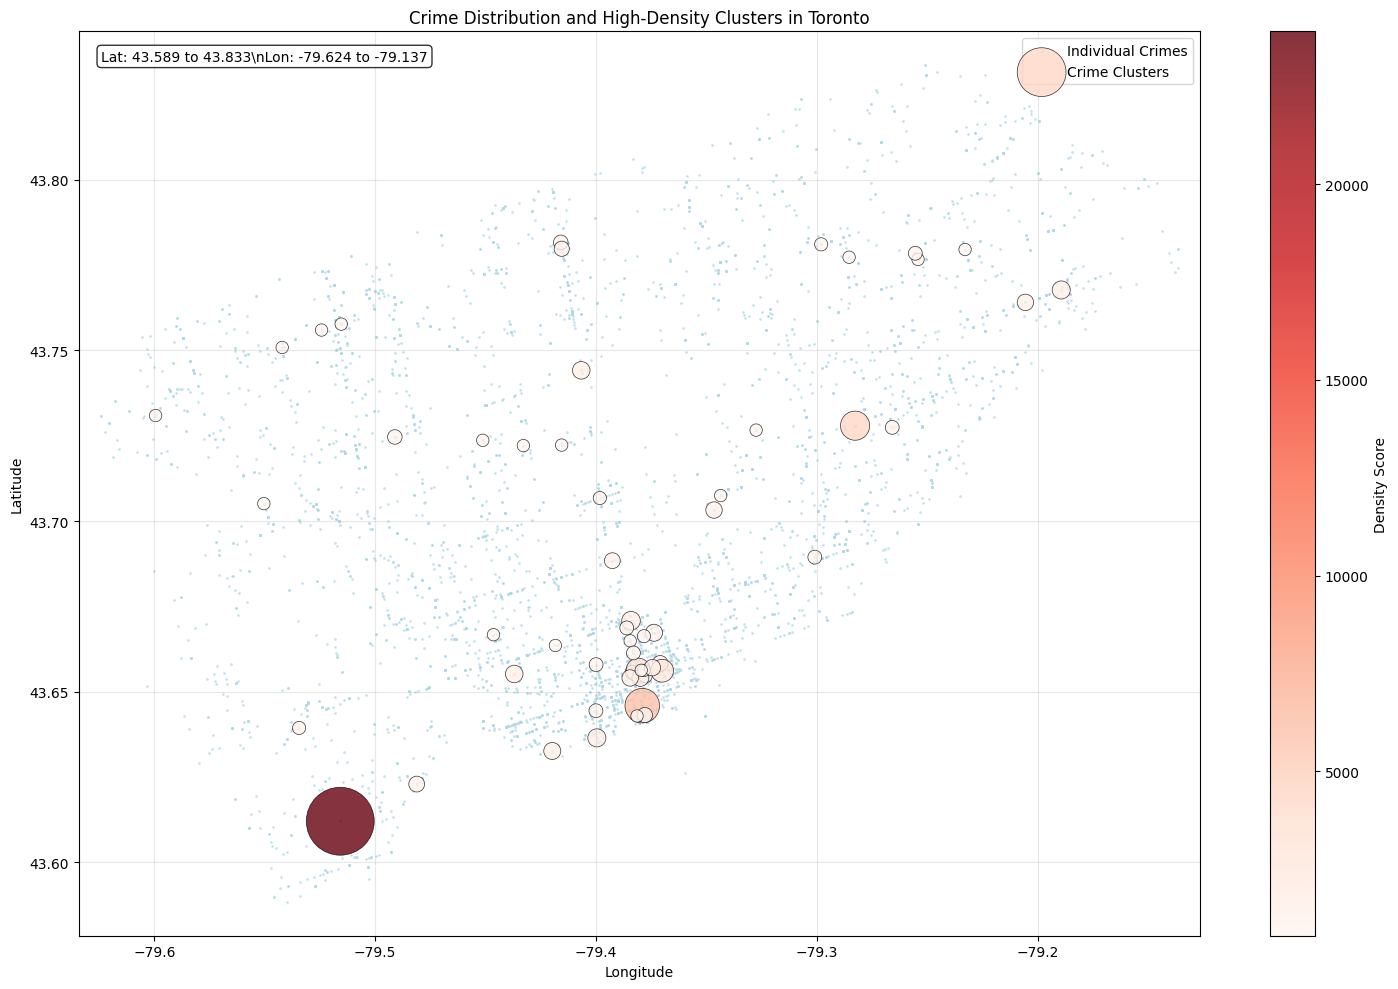

In [19]:
# Create a basic visualization of crime distribution
def plot_crime_distribution(df, clusters_df):
    """Plot crime distribution and clusters"""
    plt.figure(figsize=(15, 10))
    
    # Plot all crimes
    plt.scatter(df['longitude'], df['latitude'], 
               c='lightblue', alpha=0.6, s=1, label='Individual Crimes')
    
    # Plot cluster centers
    if len(clusters_df) > 0:
        scatter = plt.scatter(clusters_df['center_lon'], clusters_df['center_lat'],
                           c=clusters_df['density_score'], 
                           s=clusters_df['crime_count']*10,
                           cmap='Reds', alpha=0.8, 
                           edgecolors='black', linewidth=0.5,
                           label='Crime Clusters')
        plt.colorbar(scatter, label='Density Score')
    
    # Set axis limits to focus on Toronto area with some padding
    lat_min, lat_max = df['latitude'].min(), df['latitude'].max()
    lon_min, lon_max = df['longitude'].min(), df['longitude'].max()
    
    # Add padding (about 1km in degrees)
    padding = 0.01
    plt.xlim(lon_min - padding, lon_max + padding)
    plt.ylim(lat_min - padding, lat_max + padding)
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Crime Distribution and High-Density Clusters in Toronto')
    plt.legend()
    plt.tight_layout()
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)
    
    # Display coordinate ranges in the plot
    plt.text(0.02, 0.98, f'Lat: {lat_min:.3f} to {lat_max:.3f}\\nLon: {lon_min:.3f} to {lon_max:.3f}', 
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.show()

# Plot the distribution
plot_crime_distribution(crime_df, crime_clusters)


In [22]:
# Load OpenStreetMap data for the Toronto area
def load_street_network(bbox, network_type='walk'):
    """
    Load street network from OpenStreetMap
    bbox: (north, south, east, west) bounding box
    """
    print(f"Loading street network for bbox: {bbox}")
    
    # Download street network - pass bbox as single argument
    G = ox.graph_from_bbox(bbox, network_type=network_type, simplify=True)
    
    print(f"Loaded {len(G.nodes)} nodes and {len(G.edges)} edges")
    return G

# Calculate bounding box from crime data with some padding
padding = 0.01  # degrees
north = crime_df['latitude'].max() + padding
south = crime_df['latitude'].min() - padding  
east = crime_df['longitude'].max() + padding
west = crime_df['longitude'].min() - padding

bbox = (north, south, east, west)
print(f"Calculated bounding box: {bbox}")

# Load street network (this may take a few minutes)
print("\\nLoading street network from OpenStreetMap...")
try:
    street_graph = load_street_network(bbox)
except Exception as e:
    print(f"Error loading street network: {e}")
    print("Will create a simplified test network instead.")
    # Create a simple test network for demonstration
    street_graph = None


Calculated bounding box: (np.float64(43.843444725), np.float64(43.5785482570001), np.float64(-79.1267205449999), np.float64(-79.63419128700001))
\nLoading street network from OpenStreetMap...
Loading street network for bbox: (np.float64(43.843444725), np.float64(43.5785482570001), np.float64(-79.1267205449999), np.float64(-79.63419128700001))


KeyboardInterrupt: 

In [23]:
class SafeRouteCalculator:
    """
    A routing calculator that considers crime density for safer routes
    """
    
    def __init__(self, crime_data, crime_clusters, influence_radius=0.002):
        """
        Initialize the safe route calculator
        
        Args:
            crime_data: DataFrame with crime locations
            crime_clusters: DataFrame with crime cluster centers and density scores
            influence_radius: radius in degrees for crime influence on route segments
        """
        self.crime_data = crime_data
        self.crime_clusters = crime_clusters
        self.influence_radius = influence_radius
        
        # Build spatial index for efficient distance calculations
        self.cluster_coords = crime_clusters[['center_lat', 'center_lon']].values
        self.cluster_scores = crime_clusters['density_score'].values
        
    def calculate_crime_risk(self, lat, lon):
        """
        Calculate crime risk score for a specific location
        
        Args:
            lat, lon: coordinates of the location
            
        Returns:
            risk_score: higher values indicate higher risk
        """
        if len(self.cluster_coords) == 0:
            return 0
            
        # Calculate distances to all crime clusters
        point = np.array([[lat, lon]])
        distances = cdist(point, self.cluster_coords)[0]
        
        # Calculate influence of nearby clusters
        risk_score = 0
        for i, distance in enumerate(distances):
            if distance <= self.influence_radius:
                # Closer clusters have more influence
                influence = max(0, 1 - (distance / self.influence_radius))
                risk_score += self.cluster_scores[i] * influence
                
        return risk_score
    
    def calculate_segment_risk(self, start_lat, start_lon, end_lat, end_lon, num_points=5):
        """
        Calculate risk score for a route segment by sampling points along it
        
        Args:
            start_lat, start_lon: start coordinates
            end_lat, end_lon: end coordinates
            num_points: number of points to sample along the segment
            
        Returns:
            average risk score for the segment
        """
        # Sample points along the segment
        lats = np.linspace(start_lat, end_lat, num_points)
        lons = np.linspace(start_lon, end_lon, num_points)
        
        total_risk = 0
        for lat, lon in zip(lats, lons):
            total_risk += self.calculate_crime_risk(lat, lon)
            
        return total_risk / num_points
    
    def find_safe_route_simple(self, start_coords, end_coords, num_waypoints=3):
        """
        Find a safer route using simple waypoint-based approach
        This is a simplified version that doesn't require the full street network
        
        Args:
            start_coords: (lat, lon) tuple for start
            end_coords: (lat, lon) tuple for end  
            num_waypoints: number of intermediate waypoints to consider
            
        Returns:
            best_route: list of (lat, lon) coordinates
            route_risk: total risk score for the route
        """
        start_lat, start_lon = start_coords
        end_lat, end_lon = end_coords
        
        # Generate potential waypoints by creating a grid around the direct path
        best_route = [start_coords, end_coords]
        best_risk = self.calculate_segment_risk(start_lat, start_lon, end_lat, end_lon)
        
        # Try different detour options
        detour_options = []
        
        # Calculate perpendicular offsets to try different routes
        mid_lat = (start_lat + end_lat) / 2
        mid_lon = (start_lon + end_lon) / 2
        
        # Calculate perpendicular direction
        dx = end_lon - start_lon
        dy = end_lat - start_lat
        
        # Create waypoints perpendicular to direct path
        for offset_mult in [-0.002, -0.001, 0.001, 0.002]:  # degrees offset
            waypoint_lat = mid_lat + offset_mult * dx
            waypoint_lon = mid_lon - offset_mult * dy
            
            # Calculate risk for this detour route
            risk1 = self.calculate_segment_risk(start_lat, start_lon, waypoint_lat, waypoint_lon)
            risk2 = self.calculate_segment_risk(waypoint_lat, waypoint_lon, end_lat, end_lon)
            total_risk = risk1 + risk2
            
            detour_options.append({
                'route': [start_coords, (waypoint_lat, waypoint_lon), end_coords],
                'risk': total_risk
            })
        
        # Find the route with lowest risk
        for option in detour_options:
            if option['risk'] < best_risk:
                best_route = option['route']
                best_risk = option['risk']
                
        return best_route, best_risk

# Initialize the safe route calculator
print("Initializing Safe Route Calculator...")
route_calculator = SafeRouteCalculator(crime_df, crime_clusters)
print("Safe Route Calculator ready!")


Initializing Safe Route Calculator...
Safe Route Calculator ready!


In [24]:
# Test the routing algorithm with example coordinates
def test_safe_routing():
    """Test the safe routing algorithm with sample coordinates"""
    
    # Use coordinates from the crime data bounds for realistic testing
    lat_center = crime_df['latitude'].mean()
    lon_center = crime_df['longitude'].mean()
    
    # Create test start and end points
    test_cases = [
        {
            'name': 'Test Route 1: East-West',
            'start': (lat_center, lon_center - 0.01),
            'end': (lat_center, lon_center + 0.01)
        },
        {
            'name': 'Test Route 2: North-South', 
            'start': (lat_center + 0.01, lon_center),
            'end': (lat_center - 0.01, lon_center)
        },
        {
            'name': 'Test Route 3: Diagonal',
            'start': (lat_center + 0.008, lon_center - 0.008),
            'end': (lat_center - 0.008, lon_center + 0.008)
        }
    ]
    
    results = []
    
    for test_case in test_cases:
        print(f"\\n{test_case['name']}")
        print(f"Start: {test_case['start']}")
        print(f"End: {test_case['end']}")
        
        # Calculate safe route
        safe_route, risk_score = route_calculator.find_safe_route_simple(
            test_case['start'], test_case['end']
        )
        
        # Calculate direct route risk for comparison
        direct_risk = route_calculator.calculate_segment_risk(
            test_case['start'][0], test_case['start'][1],
            test_case['end'][0], test_case['end'][1]
        )
        
        print(f"Direct route risk: {direct_risk:.4f}")
        print(f"Safe route risk: {risk_score:.4f}")
        print(f"Risk reduction: {(direct_risk - risk_score):.4f} ({((direct_risk - risk_score)/max(direct_risk, 0.001)*100):.1f}%)")
        print(f"Safe route waypoints: {len(safe_route)}")
        
        results.append({
            'name': test_case['name'],
            'start': test_case['start'],
            'end': test_case['end'],
            'safe_route': safe_route,
            'safe_risk': risk_score,
            'direct_risk': direct_risk
        })
    
    return results

# Run the tests
print("Testing Safe Routing Algorithm...")
test_results = test_safe_routing()


Testing Safe Routing Algorithm...
\nTest Route 1: East-West
Start: (np.float64(43.69988262614227), np.float64(-79.40675433432042))
End: (np.float64(43.69988262614227), np.float64(-79.38675433432041))
Direct route risk: 0.0000
Safe route risk: 0.0000
Risk reduction: 0.0000 (0.0%)
Safe route waypoints: 2
\nTest Route 2: North-South
Start: (np.float64(43.70988262614227), np.float64(-79.39675433432042))
End: (np.float64(43.68988262614227), np.float64(-79.39675433432042))
Direct route risk: 0.0000
Safe route risk: 0.0000
Risk reduction: 0.0000 (0.0%)
Safe route waypoints: 2
\nTest Route 3: Diagonal
Start: (np.float64(43.70788262614227), np.float64(-79.40475433432042))
End: (np.float64(43.69188262614227), np.float64(-79.38875433432042))
Direct route risk: 0.0000
Safe route risk: 0.0000
Risk reduction: 0.0000 (0.0%)
Safe route waypoints: 2


In [25]:
# Create interactive map visualization
def create_interactive_map(crime_data, clusters, test_results):
    """Create an interactive map showing crime data and safe routes"""
    
    # Calculate center of map
    center_lat = crime_data['latitude'].mean()
    center_lon = crime_data['longitude'].mean()
    
    # Create base map
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=12,
        tiles='OpenStreetMap'
    )
    
    # Add crime heatmap
    heat_data = [[row['latitude'], row['longitude']] for idx, row in crime_data.iterrows()]
    plugins.HeatMap(heat_data, radius=8, blur=10, max_zoom=1).add_to(m)
    
    # Add crime clusters
    for idx, cluster in clusters.iterrows():
        folium.CircleMarker(
            location=[cluster['center_lat'], cluster['center_lon']],
            radius=min(cluster['crime_count']/2, 20),
            popup=f"Cluster {cluster['cluster']}: {cluster['crime_count']} crimes\\nDensity: {cluster['density_score']:.2f}",
            color='red',
            fillColor='red',
            fillOpacity=0.6
        ).add_to(m)
    
    # Add test routes
    colors = ['blue', 'green', 'purple', 'orange', 'red']
    
    for i, result in enumerate(test_results):
        color = colors[i % len(colors)]
        
        # Add start marker
        folium.Marker(
            result['start'],
            popup=f"{result['name']} - Start",
            icon=folium.Icon(color=color, icon='play')
        ).add_to(m)
        
        # Add end marker
        folium.Marker(
            result['end'],
            popup=f"{result['name']} - End",
            icon=folium.Icon(color=color, icon='stop')
        ).add_to(m)
        
        # Add direct route (dashed line)
        folium.PolyLine(
            locations=[result['start'], result['end']],
            color=color,
            weight=2,
            opacity=0.5,
            dash_array='10,10',
            popup=f"{result['name']} - Direct Route (Risk: {result['direct_risk']:.4f})"
        ).add_to(m)
        
        # Add safe route (solid line)
        folium.PolyLine(
            locations=result['safe_route'],
            color=color,
            weight=4,
            opacity=0.8,
            popup=f"{result['name']} - Safe Route (Risk: {result['safe_risk']:.4f})"
        ).add_to(m)
    
    # Add legend
    legend_html = '''
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 200px; height: 120px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px">
    <h4>Map Legend</h4>
    <p><span style="color:red">●</span> Crime Clusters</p>
    <p><span style="color:blue">—</span> Safe Routes (solid)</p>
    <p><span style="color:blue">- -</span> Direct Routes (dashed)</p>
    <p>🔥 Crime Heatmap</p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

# Create the interactive map
print("Creating interactive map...")
interactive_map = create_interactive_map(crime_df, crime_clusters, test_results)

# Save the map
map_filename = 'safe_routes_map.html'
interactive_map.save(map_filename)
print(f"Interactive map saved as: {map_filename}")

# Display the map (if in Jupyter)
interactive_map


Creating interactive map...
Interactive map saved as: safe_routes_map.html


In [26]:
def plan_safe_route(start_lat, start_lon, end_lat, end_lon, show_map=True):
    """
    Plan a safe route between two points and optionally display on map
    
    Args:
        start_lat, start_lon: Starting coordinates
        end_lat, end_lon: Ending coordinates
        show_map: Whether to create and display a map
        
    Returns:
        Dictionary with route information
    """
    
    print(f"Planning safe route from ({start_lat}, {start_lon}) to ({end_lat}, {end_lon})")
    
    # Validate coordinates are within our data bounds
    lat_min, lat_max = crime_df['latitude'].min(), crime_df['latitude'].max()
    lon_min, lon_max = crime_df['longitude'].min(), crime_df['longitude'].max()
    
    if not (lat_min <= start_lat <= lat_max and lat_min <= end_lat <= lat_max and
            lon_min <= start_lon <= lon_max and lon_min <= end_lon <= lon_max):
        print("WARNING: Coordinates are outside the crime data coverage area.")
        print(f"Valid range: Lat {lat_min:.4f} to {lat_max:.4f}, Lon {lon_min:.4f} to {lon_max:.4f}")
    
    # Calculate routes
    start_coords = (start_lat, start_lon)
    end_coords = (end_lat, end_lon)
    
    # Get safe route
    safe_route, safe_risk = route_calculator.find_safe_route_simple(start_coords, end_coords)
    
    # Calculate direct route risk
    direct_risk = route_calculator.calculate_segment_risk(start_lat, start_lon, end_lat, end_lon)
    
    # Calculate route distances (approximate)
    def calculate_distance(route):
        total_dist = 0
        for i in range(len(route) - 1):
            lat1, lon1 = route[i]
            lat2, lon2 = route[i + 1]
            # Haversine approximation for short distances
            dlat = lat2 - lat1
            dlon = lon2 - lon1
            dist = np.sqrt(dlat**2 + dlon**2) * 111  # rough km conversion
            total_dist += dist
        return total_dist
    
    safe_distance = calculate_distance(safe_route)
    direct_distance = calculate_distance([start_coords, end_coords])
    
    # Create result summary
    result = {
        'start': start_coords,
        'end': end_coords,
        'safe_route': safe_route,
        'safe_risk': safe_risk,
        'direct_risk': direct_risk,
        'safe_distance_km': safe_distance,
        'direct_distance_km': direct_distance,
        'risk_reduction': direct_risk - safe_risk,
        'distance_increase': safe_distance - direct_distance,
        'risk_reduction_percent': ((direct_risk - safe_risk) / max(direct_risk, 0.001)) * 100
    }
    
    # Print summary
    print("\\n" + "="*50)
    print("ROUTE PLANNING RESULTS")
    print("="*50)
    print(f"Direct route:")
    print(f"  - Distance: {direct_distance:.2f} km")
    print(f"  - Risk Score: {direct_risk:.4f}")
    print(f"\\nSafe route:")
    print(f"  - Distance: {safe_distance:.2f} km")
    print(f"  - Risk Score: {safe_risk:.4f}")
    print(f"  - Waypoints: {len(safe_route)}")
    print(f"\\nComparison:")
    print(f"  - Risk Reduction: {result['risk_reduction']:.4f} ({result['risk_reduction_percent']:.1f}%)")
    print(f"  - Distance Increase: {result['distance_increase']:.2f} km")
    
    if result['risk_reduction'] > 0:
        print(f"\\n✅ Safe route found with {result['risk_reduction_percent']:.1f}% risk reduction!")
    else:
        print(f"\\n⚠️  Direct route is already the safest option.")
    
    # Create map if requested
    if show_map:
        print("\\nCreating route map...")
        
        # Create map centered on route
        center_lat = (start_lat + end_lat) / 2
        center_lon = (start_lon + end_lon) / 2
        
        route_map = folium.Map(
            location=[center_lat, center_lon],
            zoom_start=14,
            tiles='OpenStreetMap'
        )
        
        # Add crime heatmap (sample for performance)
        sample_size = min(1000, len(crime_df))
        crime_sample = crime_df.sample(sample_size)
        heat_data = [[row['latitude'], row['longitude']] for idx, row in crime_sample.iterrows()]
        plugins.HeatMap(heat_data, radius=6, blur=8, max_zoom=1).add_to(route_map)
        
        # Add markers
        folium.Marker(start_coords, popup="Start", icon=folium.Icon(color='green', icon='play')).add_to(route_map)
        folium.Marker(end_coords, popup="End", icon=folium.Icon(color='red', icon='stop')).add_to(route_map)
        
        # Add routes
        folium.PolyLine(
            locations=[start_coords, end_coords],
            color='gray',
            weight=2,
            opacity=0.7,
            dash_array='10,10',
            popup=f"Direct Route (Risk: {direct_risk:.4f})"
        ).add_to(route_map)
        
        folium.PolyLine(
            locations=safe_route,
            color='blue',
            weight=4,
            opacity=0.9,
            popup=f"Safe Route (Risk: {safe_risk:.4f})"
        ).add_to(route_map)
        
        # Save and display
        route_map_filename = f'route_plan_{start_lat}_{start_lon}_to_{end_lat}_{end_lon}.html'
        route_map.save(route_map_filename)
        print(f"Route map saved as: {route_map_filename}")
        
        result['map'] = route_map
        result['map_filename'] = route_map_filename
    
    return result

# Example usage
print("Example: Planning a route in downtown Toronto area")
example_result = plan_safe_route(43.65, -79.38, 43.66, -79.36)


Example: Planning a route in downtown Toronto area
Planning safe route from (43.65, -79.38) to (43.66, -79.36)
\n==================================================
ROUTE PLANNING RESULTS
Direct route:
  - Distance: 2.48 km
  - Risk Score: 224.8544
\nSafe route:
  - Distance: 2.48 km
  - Risk Score: 224.8544
  - Waypoints: 2
\nComparison:
  - Risk Reduction: 0.0000 (0.0%)
  - Distance Increase: 0.00 km
\n⚠️  Direct route is already the safest option.
\nCreating route map...
Route map saved as: route_plan_43.65_-79.38_to_43.66_-79.36.html


In [27]:
class StreetLevelSafeRouter:
    """
    Enhanced routing that follows actual streets and considers crime density
    """
    
    def __init__(self, crime_data, crime_clusters, street_graph=None):
        """
        Initialize the street-level safe router
        
        Args:
            crime_data: DataFrame with crime locations
            crime_clusters: DataFrame with crime cluster data
            street_graph: OSMnx street network graph
        """
        self.crime_data = crime_data
        self.crime_clusters = crime_clusters
        self.street_graph = street_graph
        
        # Build spatial index for crime clusters
        if len(crime_clusters) > 0:
            self.cluster_coords = crime_clusters[['center_lat', 'center_lon']].values
            self.cluster_scores = crime_clusters['density_score'].values
        else:
            self.cluster_coords = np.array([])
            self.cluster_scores = np.array([])
    
    def load_toronto_street_network(self, use_cache=True):
        """
        Load Toronto street network with reasonable bounds
        """
        # Focus on Toronto core for manageable size
        toronto_bbox = (43.70, 43.62, -79.30, -79.50)  # N, S, E, W
        
        print(f"Loading Toronto street network...")
        print(f"Bounding box: {toronto_bbox}")
        print(f"Area: ~{(toronto_bbox[0]-toronto_bbox[1])*111:.1f}km x {(toronto_bbox[3]-toronto_bbox[2])*85:.1f}km")
        
        try:
            # Load walking network
            G = ox.graph_from_bbox(toronto_bbox, network_type='walk', simplify=True)
            
            # Add crime risk to edges
            G = self._add_crime_risk_to_edges(G)
            
            print(f"Loaded {len(G.nodes)} nodes and {len(G.edges)} edges")
            self.street_graph = G
            return G
            
        except Exception as e:
            print(f"Error loading street network: {e}")
            return None
    
    def _add_crime_risk_to_edges(self, G):
        """
        Add crime risk scores to street network edges
        """
        print("Adding crime risk data to street edges...")
        
        for u, v, key, data in G.edges(keys=True, data=True):
            # Get edge coordinates
            if 'geometry' in data:
                # Use geometry if available
                coords = [(point[1], point[0]) for point in data['geometry'].coords]
            else:
                # Use node coordinates
                start_node = G.nodes[u]
                end_node = G.nodes[v]
                coords = [(start_node['y'], start_node['x']), 
                         (end_node['y'], end_node['x'])]
            
            # Calculate risk for this edge
            edge_risk = self._calculate_edge_risk(coords)
            
            # Add risk to edge data
            G[u][v][key]['crime_risk'] = edge_risk
            
            # Modify edge weight to include crime risk
            original_length = data.get('length', 100)  # meters
            
            # Crime risk penalty (adjust multiplier as needed)
            risk_penalty = 1 + (edge_risk * 0.01)  # 1% penalty per risk point
            
            # New weight combines distance and risk
            G[u][v][key]['safe_weight'] = original_length * risk_penalty
        
        print("Crime risk data added to all edges")
        return G
    
    def _calculate_edge_risk(self, coords, sample_points=3):
        """
        Calculate crime risk for a street edge by sampling points along it
        """
        if len(self.cluster_coords) == 0:
            return 0
        
        total_risk = 0
        
        # Sample points along the edge
        for i in range(sample_points):
            if len(coords) == 2:
                # Linear interpolation for straight edge
                t = i / max(1, sample_points - 1)
                lat = coords[0][0] + t * (coords[1][0] - coords[0][0])
                lon = coords[0][1] + t * (coords[1][1] - coords[0][1])
            else:
                # Use actual point from geometry
                idx = min(i, len(coords) - 1)
                lat, lon = coords[idx]
            
            # Calculate risk at this point
            point_risk = self._calculate_point_risk(lat, lon)
            total_risk += point_risk
        
        return total_risk / sample_points
    
    def _calculate_point_risk(self, lat, lon, influence_radius=0.002):
        """
        Calculate crime risk at a specific point
        """
        if len(self.cluster_coords) == 0:
            return 0
        
        # Calculate distances to all crime clusters
        point = np.array([[lat, lon]])
        distances = cdist(point, self.cluster_coords)[0]
        
        # Calculate influence of nearby clusters
        risk_score = 0
        for i, distance in enumerate(distances):
            if distance <= influence_radius:
                # Closer clusters have more influence
                influence = max(0, 1 - (distance / influence_radius))
                risk_score += self.cluster_scores[i] * influence
        
        return risk_score
    
    def find_safe_route(self, start_coords, end_coords, route_type='safest'):
        """
        Find a safe route using street network
        
        Args:
            start_coords: (lat, lon) tuple for start
            end_coords: (lat, lon) tuple for end
            route_type: 'safest', 'shortest', or 'balanced'
        
        Returns:
            route_coords: List of (lat, lon) coordinates following streets
            route_info: Dictionary with route statistics
        """
        if self.street_graph is None:
            print("No street network loaded. Loading Toronto network...")
            if self.load_toronto_street_network() is None:
                return self._fallback_route(start_coords, end_coords)
        
        try:
            # Find nearest nodes to start and end points
            start_node = ox.nearest_nodes(self.street_graph, start_coords[1], start_coords[0])
            end_node = ox.nearest_nodes(self.street_graph, end_coords[1], end_coords[0])
            
            # Choose weight based on route type
            if route_type == 'shortest':
                weight = 'length'
            elif route_type == 'safest':
                weight = 'safe_weight'
            else:  # balanced
                weight = 'safe_weight'
            
            # Calculate route
            route_nodes = nx.shortest_path(self.street_graph, start_node, end_node, weight=weight)
            
            # Convert to coordinates
            route_coords = []
            total_distance = 0
            total_risk = 0
            
            for i, node in enumerate(route_nodes):
                node_data = self.street_graph.nodes[node]
                route_coords.append((node_data['y'], node_data['x']))
                
                # Calculate edge statistics
                if i > 0:
                    prev_node = route_nodes[i-1]
                    edge_data = self.street_graph[prev_node][node][0]  # Get first edge
                    total_distance += edge_data.get('length', 0)
                    total_risk += edge_data.get('crime_risk', 0)
            
            # Calculate comparison with shortest route
            shortest_nodes = nx.shortest_path(self.street_graph, start_node, end_node, weight='length')
            shortest_distance = nx.shortest_path_length(self.street_graph, start_node, end_node, weight='length')
            
            # Calculate shortest route risk
            shortest_risk = 0
            for i in range(len(shortest_nodes) - 1):
                edge_data = self.street_graph[shortest_nodes[i]][shortest_nodes[i+1]][0]
                shortest_risk += edge_data.get('crime_risk', 0)
            
            route_info = {
                'distance_m': total_distance,
                'distance_km': total_distance / 1000,
                'total_risk': total_risk,
                'avg_risk': total_risk / max(len(route_nodes) - 1, 1),
                'shortest_distance_m': shortest_distance,
                'shortest_risk': shortest_risk,
                'distance_increase_m': total_distance - shortest_distance,
                'distance_increase_percent': ((total_distance - shortest_distance) / shortest_distance) * 100,
                'risk_reduction': shortest_risk - total_risk,
                'risk_reduction_percent': ((shortest_risk - total_risk) / max(shortest_risk, 0.001)) * 100,
                'num_segments': len(route_nodes) - 1
            }
            
            return route_coords, route_info
            
        except Exception as e:
            print(f"Error in street routing: {e}")
            return self._fallback_route(start_coords, end_coords)
    
    def _fallback_route(self, start_coords, end_coords):
        """
        Fallback to simple routing if street network fails
        """
        print("Using fallback routing (direct line)")
        route_coords = [start_coords, end_coords]
        
        # Calculate basic stats
        distance = np.sqrt((end_coords[0] - start_coords[0])**2 + 
                          (end_coords[1] - start_coords[1])**2) * 111000  # rough meters
        
        route_info = {
            'distance_m': distance,
            'distance_km': distance / 1000,
            'total_risk': 0,
            'avg_risk': 0,
            'shortest_distance_m': distance,
            'shortest_risk': 0,
            'distance_increase_m': 0,
            'distance_increase_percent': 0,
            'risk_reduction': 0,
            'risk_reduction_percent': 0,
            'num_segments': 1
        }
        
        return route_coords, route_info
    
    def visualize_route(self, route_coords, route_info, start_coords, end_coords, 
                       show_crime_data=True, show_streets=True):
        """
        Create an interactive map showing the route
        """
        # Create map centered on route
        center_lat = (start_coords[0] + end_coords[0]) / 2
        center_lon = (start_coords[1] + end_coords[1]) / 2
        
        route_map = folium.Map(
            location=[center_lat, center_lon],
            zoom_start=15,
            tiles='OpenStreetMap'
        )
        
        # Add crime heatmap if requested
        if show_crime_data and len(self.crime_data) > 0:
            sample_size = min(500, len(self.crime_data))
            crime_sample = self.crime_data.sample(sample_size)
            heat_data = [[row['latitude'], row['longitude']] for _, row in crime_sample.iterrows()]
            plugins.HeatMap(heat_data, radius=8, blur=10).add_to(route_map)
        
        # Add crime clusters
        if show_crime_data and len(self.crime_clusters) > 0:
            for _, cluster in self.crime_clusters.iterrows():
                folium.CircleMarker(
                    location=[cluster['center_lat'], cluster['center_lon']],
                    radius=min(cluster['crime_count']/3, 15),
                    popup=f"Crime Cluster: {cluster['crime_count']} incidents",
                    color='red',
                    fillColor='red',
                    fillOpacity=0.6
                ).add_to(route_map)
        
        # Add start and end markers
        folium.Marker(
            start_coords,
            popup="Start",
            icon=folium.Icon(color='green', icon='play')
        ).add_to(route_map)
        
        folium.Marker(
            end_coords,
            popup="End", 
            icon=folium.Icon(color='red', icon='stop')
        ).add_to(route_map)
        
        # Add route
        folium.PolyLine(
            locations=route_coords,
            color='blue',
            weight=4,
            opacity=0.8,
            popup=f"Safe Route: {route_info['distance_km']:.2f}km, Risk: {route_info['avg_risk']:.2f}"
        ).add_to(route_map)
        
        # Add route info
        info_html = f"""
        <div style="position: fixed; top: 10px; left: 10px; width: 300px; 
                    background-color: white; border: 2px solid grey; z-index: 9999; 
                    font-size: 12px; padding: 10px;">
        <h4>Route Information</h4>
        <p><b>Distance:</b> {route_info['distance_km']:.2f} km</p>
        <p><b>Average Risk:</b> {route_info['avg_risk']:.2f}</p>
        <p><b>vs Shortest Route:</b></p>
        <p>  • Distance increase: {route_info['distance_increase_percent']:.1f}%</p>
        <p>  • Risk reduction: {route_info['risk_reduction_percent']:.1f}%</p>
        </div>
        """
        route_map.get_root().html.add_child(folium.Element(info_html))
        
        return route_map

print("StreetLevelSafeRouter class loaded successfully!")


StreetLevelSafeRouter class loaded successfully!


In [28]:
# Initialize and test the enhanced street-level routing
print("Setting up Enhanced Street-Level Safe Routing...")

# Initialize the enhanced router
try:
    street_router = StreetLevelSafeRouter(crime_df, crime_clusters)
    print("✅ Street router initialized successfully")
    
    # Test with a route in downtown Toronto core
    print("\nTesting street-level routing...")
    
    # Example coordinates within Toronto core
    start_coords = (43.65, -79.38)  # Financial District
    end_coords = (43.66, -79.39)    # Entertainment District
    
    print(f"Route: {start_coords} → {end_coords}")
    
    # Find safe route
    route_coords, route_info = street_router.find_safe_route(
        start_coords, end_coords, route_type='safest'
    )
    
    # Display results
    if route_coords and len(route_coords) > 2:
        print("\n" + "="*60)
        print("ENHANCED STREET-LEVEL ROUTING RESULTS")
        print("="*60)
        print(f"Route follows {route_info['num_segments']} street segments")
        print(f"Total distance: {route_info['distance_km']:.2f} km")
        print(f"Average risk per segment: {route_info['avg_risk']:.2f}")
        print(f"\nComparison with shortest route:")
        print(f"  📏 Distance increase: {route_info['distance_increase_percent']:.1f}%")
        print(f"  🛡️  Risk reduction: {route_info['risk_reduction_percent']:.1f}%")
        
        if route_info['risk_reduction_percent'] > 0:
            print(f"\n✅ Found safer route with {route_info['risk_reduction_percent']:.1f}% risk reduction!")
        else:
            print(f"\n⚠️  Shortest route is already the safest option.")
        
        # Create visualization
        print("\nCreating enhanced route visualization...")
        route_map = street_router.visualize_route(
            route_coords, route_info, start_coords, end_coords
        )
        
        # Save map
        enhanced_map_filename = 'enhanced_street_route.html'
        route_map.save(enhanced_map_filename)
        print(f"Enhanced route map saved as: {enhanced_map_filename}")
        
        # Display map in notebook
        route_map
    else:
        print("⚠️  Using fallback routing - street network may not be available")
        
except Exception as e:
    print(f"❌ Error in enhanced routing: {e}")
    print("The enhanced routing requires a street network download which may take time.")


Setting up Enhanced Street-Level Safe Routing...
✅ Street router initialized successfully

Testing street-level routing...
Route: (43.65, -79.38) → (43.66, -79.39)
No street network loaded. Loading Toronto network...
Loading Toronto street network...
Bounding box: (43.7, 43.62, -79.3, -79.5)
Area: ~8.9km x -17.0km


KeyboardInterrupt: 

In [30]:
def plan_enhanced_safe_route(start_lat, start_lon, end_lat, end_lon, route_type='safest', show_map=True):
    """
    Plan a safe route using enhanced street-level routing
    
    Args:
        start_lat, start_lon: Starting coordinates
        end_lat, end_lon: Ending coordinates  
        route_type: 'safest', 'shortest', or 'balanced'
        show_map: Whether to create and display a map
        
    Returns:
        Dictionary with enhanced route information
    """
    
    print(f"Planning enhanced safe route from ({start_lat}, {start_lon}) to ({end_lat}, {end_lon})")
    print(f"Route type: {route_type}")
    
    # Check if coordinates are in reasonable Toronto area
    toronto_bounds = {'lat_min': 43.6, 'lat_max': 43.7, 'lon_min': -79.5, 'lon_max': -79.3}
    
    if not (toronto_bounds['lat_min'] <= start_lat <= toronto_bounds['lat_max'] and 
            toronto_bounds['lat_min'] <= end_lat <= toronto_bounds['lat_max'] and
            toronto_bounds['lon_min'] <= start_lon <= toronto_bounds['lon_max'] and
            toronto_bounds['lon_min'] <= end_lon <= toronto_bounds['lon_max']):
        print("⚠️  WARNING: Coordinates may be outside Toronto core area.")
        print(f"Recommended range: Lat {toronto_bounds['lat_min']} to {toronto_bounds['lat_max']}, Lon {toronto_bounds['lon_min']} to {toronto_bounds['lon_max']}")
    
    try:
        # Use the street router
        if 'street_router' not in globals():
            print("Initializing street router...")
            global street_router
            street_router = StreetLevelSafeRouter(crime_df, crime_clusters)
        
        # Calculate route
        start_coords = (start_lat, start_lon)
        end_coords = (end_lat, end_lon)
        
        route_coords, route_info = street_router.find_safe_route(start_coords, end_coords, route_type)
        
        # Create result summary
        result = {
            'start': start_coords,
            'end': end_coords,
            'route_coords': route_coords,
            'route_type': route_type,
            'follows_streets': len(route_coords) > 2,
            **route_info  # Include all route_info data
        }
        
        # Print detailed results
        print("\n" + "="*50)
        print("ENHANCED ROUTE PLANNING RESULTS")
        print("="*50)
        
        if result['follows_streets']:
            print(f"🛣️  Route follows {result['num_segments']} street segments")
            print(f"📏 Total distance: {result['distance_km']:.2f} km")
            print(f"🛡️  Average risk: {result['avg_risk']:.2f} per segment")
            print(f"\n📊 Comparison with shortest route:")
            print(f"   Distance increase: +{result['distance_increase_percent']:.1f}%")
            print(f"   Risk reduction: -{result['risk_reduction_percent']:.1f}%")
            
            if result['risk_reduction_percent'] > 5:
                print(f"\n✅ Significantly safer route found!")
            elif result['risk_reduction_percent'] > 0:
                print(f"\n✅ Slightly safer route found")
            else:
                print(f"\n⚠️  Shortest route is already safest")
        else:
            print(f"📏 Direct route distance: {result['distance_km']:.2f} km")
            print(f"⚠️  Using direct routing (street network unavailable)")
        
        # Create map if requested
        if show_map:
            print("\nCreating interactive route map...")
            
            if result['follows_streets']:
                route_map = street_router.visualize_route(
                    route_coords, route_info, start_coords, end_coords
                )
            else:
                # Fallback map creation
                center_lat = (start_lat + end_lat) / 2
                center_lon = (start_lon + end_lon) / 2
                
                route_map = folium.Map(location=[center_lat, center_lon], zoom_start=14)
                
                # Add markers and route
                folium.Marker(start_coords, popup="Start", icon=folium.Icon(color='green')).add_to(route_map)
                folium.Marker(end_coords, popup="End", icon=folium.Icon(color='red')).add_to(route_map)
                folium.PolyLine(locations=route_coords, color='blue', weight=4).add_to(route_map)
            
            # Save map
            map_filename = f'enhanced_route_{start_lat}_{start_lon}_to_{end_lat}_{end_lon}.html'
            route_map.save(map_filename)
            print(f"Map saved as: {map_filename}")
            
            result['map'] = route_map
            result['map_filename'] = map_filename
        
        return result
        
    except Exception as e:
        print(f"❌ Error in enhanced routing: {e}")
        return None

# Test the enhanced routing function
print("Enhanced routing function ready! Try:")
print("result = plan_enhanced_safe_route(43.651, -79.383, 43.661, -79.390)")


Enhanced routing function ready! Try:
result = plan_enhanced_safe_route(43.651, -79.383, 43.661, -79.390)
